In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
#reading the dataset
df = pd.read_csv('measurements.csv')

In [3]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    int64 
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    int64 
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    int64 
 8   rain           388 non-null    int64 
 9   sun            388 non-null    int64 
 10  refill liters  13 non-null     object
 11  refill gas     13 non-null     object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


In [4]:
# converting the object datatype to integer
df['distance'] = df['distance'].str.replace(',', '.').astype(float)
df['consume'] = df['consume'].str.replace(',', '.').astype(float)
df['temp_inside'] = pd.to_numeric(df['temp_inside'].str.replace(',', '.'), errors='coerce')  # Using coerce for NaNs in case of missing values


distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64


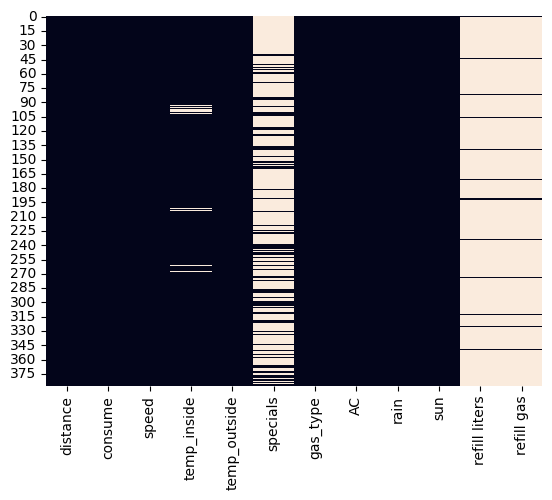

In [5]:
# Print the missing values
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Visualize missing values
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [6]:
# removing the columns which have more null values.
df.drop(['specials','refill liters','refill gas'], axis=1, inplace=True)

In [7]:
# label encode the gas_type column
le = LabelEncoder()
df['gas_type'] = le.fit_transform(df['gas_type'])

In [8]:
# info about the clean data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   distance      388 non-null    float64
 1   consume       388 non-null    float64
 2   speed         388 non-null    int64  
 3   temp_inside   376 non-null    float64
 4   temp_outside  388 non-null    int64  
 5   gas_type      388 non-null    int32  
 6   AC            388 non-null    int64  
 7   rain          388 non-null    int64  
 8   sun           388 non-null    int64  
dtypes: float64(3), int32(1), int64(5)
memory usage: 25.9 KB


In [9]:
# normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_features = ['distance', 'consume', 'speed', 'temp_inside', 'temp_outside']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [10]:
# Clustering
from sklearn.cluster import KMeans

# Selecting features for clustering
cluster_features = ['distance', 'consume', 'speed']
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(df[cluster_features])

# Mapping clusters to labels
cluster_labels = {0: 'Calm', 1: 'Normal', 2: 'Eco', 3: 'Aggressive'}
df['driver_profile'] = df['cluster'].map(cluster_labels)

In [11]:
from sklearn.impute import SimpleImputer

# Define the columns with missing values
numerical_cols = ['speed', 'temp_outside', 'AC', 'rain', 'sun']

# Initialize the imputer for the specified columns
imputer = SimpleImputer(strategy='mean')

# Apply imputer to the specified columns
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Check if there are any remaining NaN values in the specified columns
print(df[numerical_cols].isna().sum())

speed           0
temp_outside    0
AC              0
rain            0
sun             0
dtype: int64


In [12]:
# Check for NaN values in other columns used for clustering or regression
print(df[['distance', 'consume', 'temp_inside']].isna().sum())

distance        0
consume         0
temp_inside    12
dtype: int64


In [13]:
# Define the imputer for 'temp_inside' column
imputer_temp_inside = SimpleImputer(strategy='mean')

# Apply imputer to 'temp_inside'
df[['temp_inside']] = imputer_temp_inside.fit_transform(df[['temp_inside']])

# Check if there are any remaining NaN values
print(df[['temp_inside']].isna().sum())

temp_inside    0
dtype: int64


Random Forest Regressor: MSE = 0.62, MAE = 0.48
Ridge Regression: MSE = 1.41, MAE = 0.67
AdaBoostRegressor: MSE = 0.88, MAE = 0.56
XGBRFRegressor: MSE = 0.65, MAE = 0.49
SVR: MSE = 1.04, MAE = 0.61


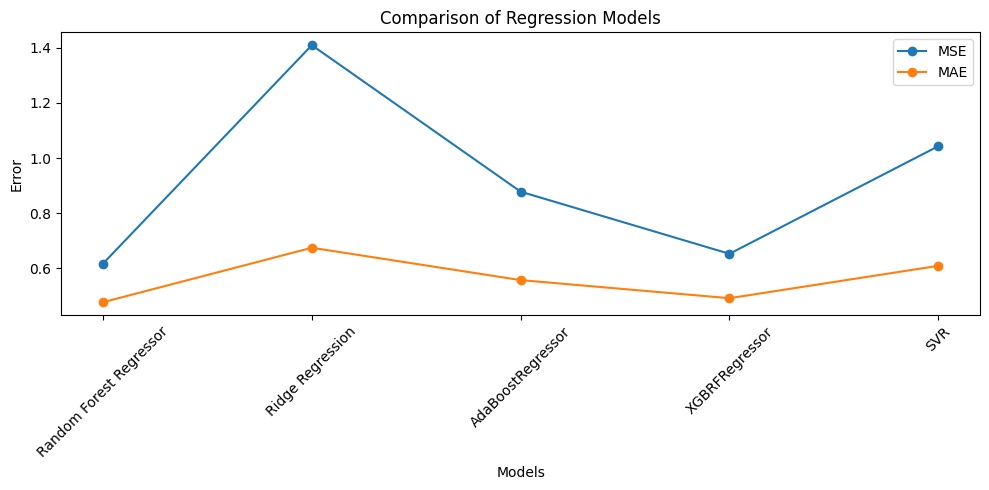

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRFRegressor
from sklearn.svm import SVR

# Define features and target
X = df[['distance', 'AC', 'speed', 'rain','temp_inside', 'temp_outside','sun','gas_type']]
y = df['consume']  

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the models
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Ridge Regression': Ridge(),
    'AdaBoostRegressor': AdaBoostRegressor(),
    'XGBRFRegressor': XGBRFRegressor(),
    'SVR': SVR()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae}

# Print results
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.2f}, MAE = {metrics['MAE']:.2f}")

# Optional: Plot comparison graph
import matplotlib.pyplot as plt

names = list(results.keys())
mse_values = [metrics['MSE'] for metrics in results.values()]
mae_values = [metrics['MAE'] for metrics in results.values()]

plt.figure(figsize=(10, 5))
plt.plot(names, mse_values, label='MSE', marker='o')
plt.plot(names, mae_values, label='MAE', marker='o')
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Comparison of Regression Models')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
df['rain'].value_counts()

rain
0.0    340
1.0     48
Name: count, dtype: int64

In [16]:
df['sun'].value_counts()

sun
0.0    356
1.0     32
Name: count, dtype: int64

In [17]:
df['AC'].value_counts()

AC
0.0    358
1.0     30
Name: count, dtype: int64

In [18]:
# import pandas as pd
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from sklearn.linear_model import Ridge
# from xgboost import XGBRFRegressor
# from sklearn.svm import SVR
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import matplotlib.pyplot as plt

# # Assuming df is your dataframe
# # Define features and target
# X = df[['distance', 'AC', 'speed', 'rain', 'temp_inside', 'temp_outside', 'sun']]
# y = df['consume']

# # Combine X and y to balance the data
# df_combined = pd.concat([X, y], axis=1)

# # Separate the categorical columns that need balancing
# cat_columns = ['AC', 'rain', 'sun']

# # Balancing the categorical columns
# for column in cat_columns:
#     rus = RandomUnderSampler(random_state=42)
#     df_balanced, _ = rus.fit_resample(df_combined, df_combined[column])
#     df_combined = df_balanced

# # Split the balanced data into features and target
# X_balanced = df_combined[['distance', 'AC', 'speed', 'rain', 'temp_inside', 'temp_outside', 'sun']]
# y_balanced = df_combined['consume']

# # Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=0)

# # Define the models
# models = {
#     'Random Forest Regressor': RandomForestRegressor(),
#     'Ridge Regression': Ridge(),
#     'AdaBoostRegressor': AdaBoostRegressor(),
#     'XGBRFRegressor': XGBRFRegressor(),
#     'SVR': SVR()
# }

# # Train and evaluate models
# results = {}
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     results[name] = {'MSE': mse, 'MAE': mae}

# # Print results
# for name, metrics in results.items():
#     print(f"{name}: MSE = {metrics['MSE']:.2f}, MAE = {metrics['MAE']:.2f}")

# # Optional: Plot comparison graph
# names = list(results.keys())
# mse_values = [metrics['MSE'] for metrics in results.values()]
# mae_values = [metrics['MAE'] for metrics in results.values()]

# plt.figure(figsize=(10, 5))
# plt.plot(names, mse_values, label='MSE', marker='o')
# plt.plot(names, mae_values, label='MAE', marker='o')
# plt.xlabel('Models')
# plt.ylabel('Error')
# plt.title('Comparison of Regression Models')
# plt.legend()
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()